<a href="https://colab.research.google.com/github/jaysalomon/Bio-Spin/blob/main/Reservoir_Computing_Simulation_Setup_(CPU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating 20 random magnetosome positions...
Generated reservoir with 20 magnetosomes.
Running simulation from t=0 to t=5e-09...
Simulation finished in 225.53 seconds.
Reservoir state matrix shape: (60, 501)


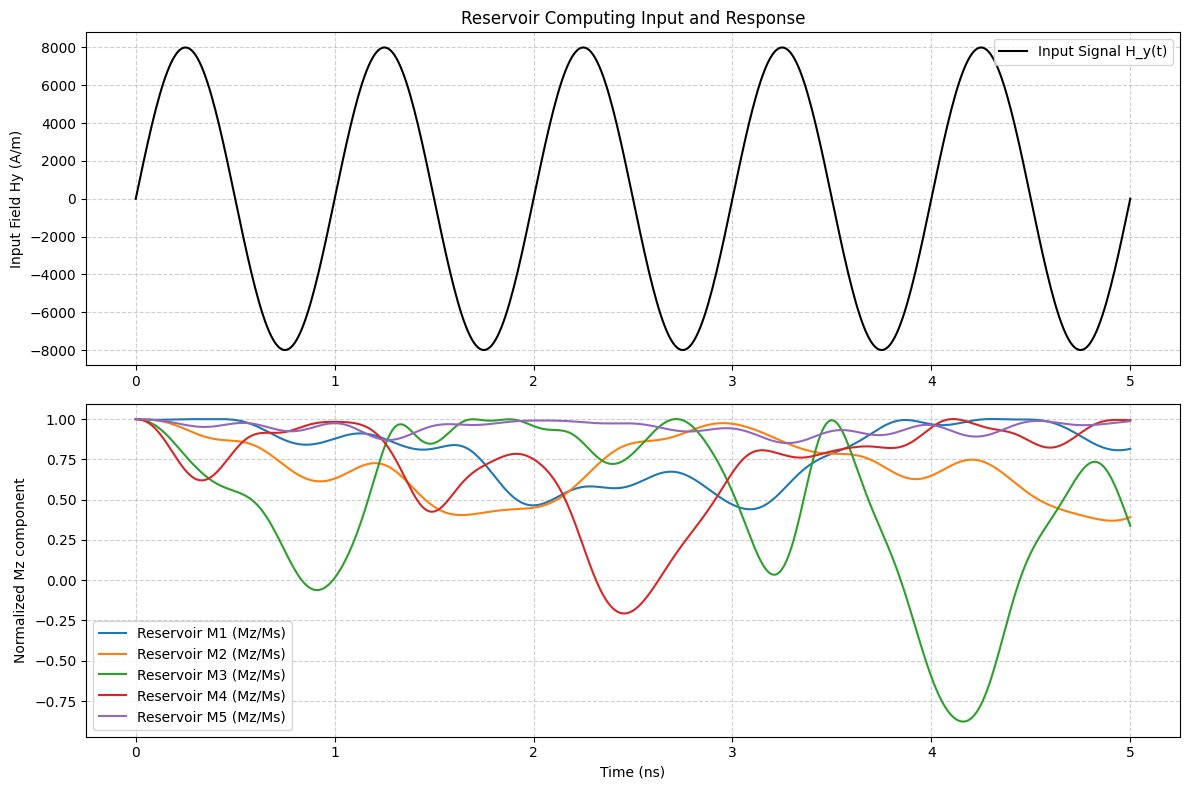


Generating 3D plot of the final reservoir state...


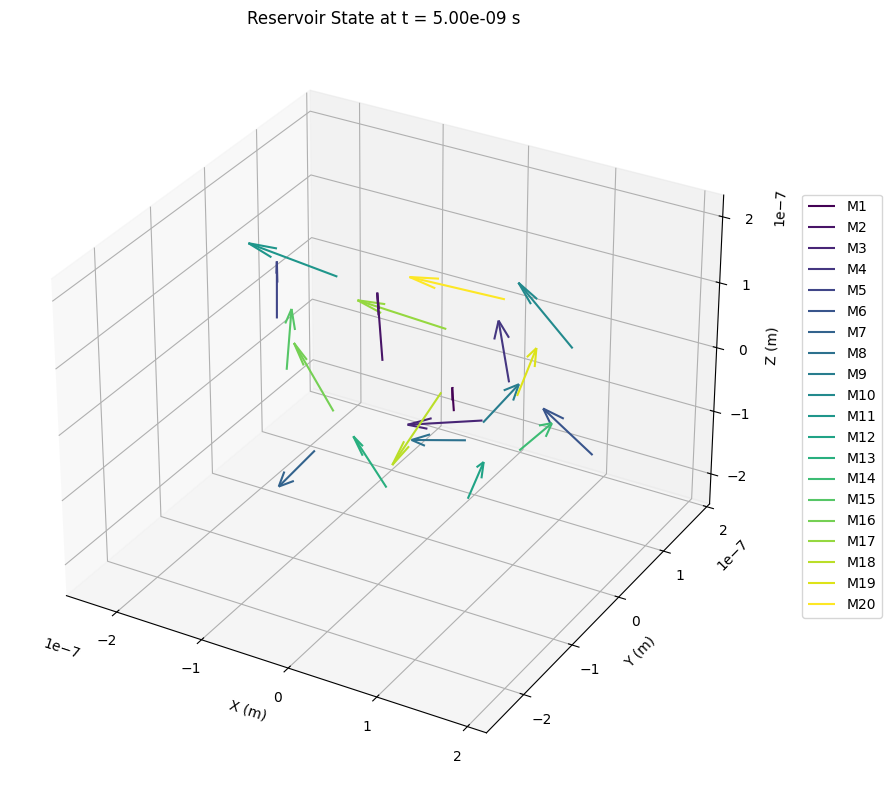


--- Performing Input Reconstruction Task ---
Feature matrix X shape: (501, 60)
Target vector y shape: (501,)
Training Ridge regression model...
Training finished in 0.034 seconds.
Predicting input signal using trained readout...
Mean Squared Error (MSE) of reconstruction: 2.17e-01


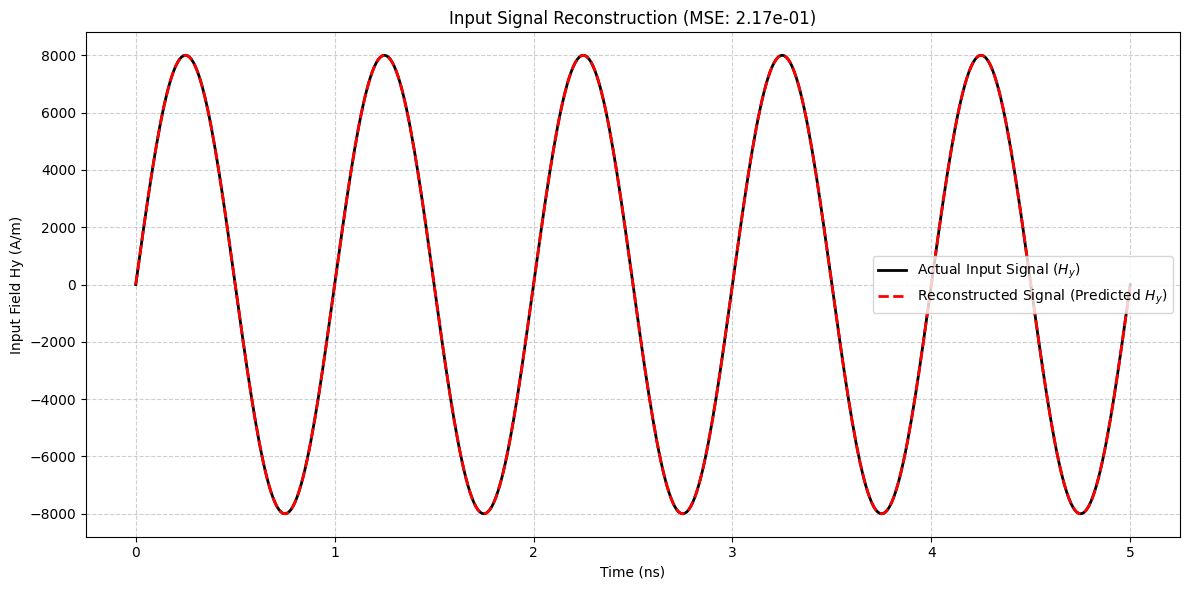

Input reconstruction analysis complete.


In [1]:
# Import necessary libraries
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Ensure 3D toolkit is imported
import time

# --- Added imports for Input Reconstruction ---
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
# May need: !pip install scikit-learn

# --- Assume Magnetosome and Simulation classes are defined here ---
# <<< PASTE the Magnetosome and Simulation class definitions here >>>
# --- Physical Constants ---
GAMMA_LL = 2.2128e5
ALPHA = 0.05 # Slightly higher damping might be typical for reservoirs
MS = 4.8e5
KB = 1.380649e-23
# T_TEMP = 300 # Temperature - Set to 0 for initial reservoir test
MU0 = 4 * np.pi * 1e-7

class Magnetosome:
    """ Represents a single magnetosome nanoparticle. (Copied from thermal_stability_sim) """
    def __init__(self, position, initial_M_direction, volume, Ku, easy_axis=[0, 0, 1]):
        self.pos = np.array(position, dtype=float)
        initial_M_direction = np.array(initial_M_direction, dtype=float)
        norm = np.linalg.norm(initial_M_direction)
        if norm < 1e-9: raise ValueError("Initial magnetization direction cannot be a zero vector.")
        self.M = (initial_M_direction / norm) * MS
        self.V = float(volume)
        self.Ku = float(Ku)
        self.Ms = MS
        self.easy_axis = np.array(easy_axis, dtype=float)
        norm_ea = np.linalg.norm(self.easy_axis)
        if norm_ea < 1e-9: raise ValueError("Easy axis cannot be a zero vector.")
        self.easy_axis /= norm_ea

    def anisotropy_field(self):
        M_norm = np.linalg.norm(self.M)
        if M_norm < 1e-9: return np.zeros(3)
        M_unit = self.M / M_norm
        M_physical = M_unit * self.Ms
        M_dot_easy_axis = np.dot(M_physical, self.easy_axis)
        # Corrected formula application:
        H_anis_magnitude = (2 * self.Ku) / (MU0 * self.Ms) # Field magnitude factor
        # Field = Factor * Projection * EasyAxisDirection
        H_anis = H_anis_magnitude * (M_dot_easy_axis / self.Ms) * self.easy_axis
        return H_anis

    def normalize_M(self):
         norm_M = np.linalg.norm(self.M)
         if norm_M > 1e-9: self.M = (self.M / norm_M) * self.Ms

class Simulation:
    """ Manages the simulation environment. (Modified for Reservoir) """
    def __init__(self, magnetosomes, H_ext_func, temperature=0, approx_dt=1e-12):
        """
        Initializes the Simulation instance for Reservoir Computing.

        Args:
            magnetosomes (list): List of Magnetosome objects forming the reservoir.
            H_ext_func (callable): A function H_ext_func(t) that returns the 3D external
                                   magnetic field vector (A/m) at time t (s).
            temperature (float): Temperature in Kelvin for thermal field calculation.
                                 Set to 0 to disable thermal noise initially.
            approx_dt (float): Approximate time step used for scaling thermal noise
                               (if temperature > 0).
        """
        self.magnetosomes = magnetosomes
        # Store the function, not a static vector
        self.H_ext_func = H_ext_func
        self.temperature = temperature
        self.approx_dt = approx_dt # Store the approximate dt

    def calculate_dipolar_field(self, target_index, current_M_vectors):
        # (Identical to previous version)
        H_dip = np.zeros(3)
        target_magnetosome = self.magnetosomes[target_index]
        for i, other_magnetosome in enumerate(self.magnetosomes):
            if i == target_index: continue
            r_vec = target_magnetosome.pos - other_magnetosome.pos
            r_dist = np.linalg.norm(r_vec)
            if r_dist < 1e-12: continue # Avoid overlap issues
            r_hat = r_vec / r_dist
            M_j = current_M_vectors[i]
            m_j = M_j * other_magnetosome.V # Magnetic moment
            term1 = 3 * np.dot(m_j, r_hat) * r_hat
            term2 = m_j
            # Correct dipolar field formula H = (1/(4pi r^3)) * [3(m.r_hat)r_hat - m]
            H_dip += (1 / (4 * np.pi * r_dist**3)) * (term1 - term2)
        return H_dip

    def calculate_thermal_field(self, magnetosome):
        # (Identical to previous version)
        if self.temperature <= 0 or self.approx_dt <= 0:
            return np.zeros(3)
        thermal_strength_factor = np.sqrt(
            (2 * ALPHA * KB * self.temperature) /
            (GAMMA_LL * MU0 * magnetosome.Ms * magnetosome.V * self.approx_dt)
        )
        random_gaussian = np.random.normal(0.0, 1.0, 3)
        H_th = thermal_strength_factor * random_gaussian
        return H_th

    def calculate_Heff(self, index, current_M_vectors, t):
        # (Identical to previous version)
        magnetosome = self.magnetosomes[index]
        H_ext_t = self.H_ext_func(t) # Call the function
        original_M = magnetosome.M.copy()
        magnetosome.M = current_M_vectors[index]
        H_anis = magnetosome.anisotropy_field()
        magnetosome.M = original_M
        H_dip = self.calculate_dipolar_field(index, current_M_vectors)
        H_th = self.calculate_thermal_field(magnetosome)
        H_eff = H_ext_t + H_anis + H_dip + H_th
        return H_eff

    def llg_equation(self, t, M_flat):
        # (Identical to previous version)
        dM_dt_flat = np.zeros_like(M_flat)
        num_magnetosomes = len(self.magnetosomes)
        current_M_vectors = {i: M_flat[i*3:(i+1)*3] for i in range(num_magnetosomes)}
        for i in range(num_magnetosomes):
            M = current_M_vectors[i]
            Ms_i = self.magnetosomes[i].Ms
            if Ms_i < 1e-9 or np.linalg.norm(M) < 1e-9:
                 dM_dt_flat[i*3:(i+1)*3] = np.zeros(3)
                 continue
            H_eff = self.calculate_Heff(i, current_M_vectors, t)
            prefactor1 = -GAMMA_LL / (1 + ALPHA**2)
            safe_Ms_i = Ms_i if Ms_i > 1e-12 else 1.0
            prefactor2 = prefactor1 * ALPHA / safe_Ms_i
            M_cross_Heff = np.cross(M, H_eff)
            M_cross_M_cross_Heff = np.cross(M, M_cross_Heff)
            dM_dt = prefactor1 * M_cross_Heff + prefactor2 * M_cross_M_cross_Heff
            dM_dt_flat[i*3:(i+1)*3] = dM_dt
        return dM_dt_flat

    def run(self, t_span, dt_max, t_eval=None):
        # (Identical to previous version)
        self.approx_dt = dt_max
        initial_M_flat = np.concatenate([m.M for m in self.magnetosomes])
        print(f"Running simulation from t={t_span[0]} to t={t_span[1]}...")
        start_sim_time = time.time()
        sol = solve_ivp(
            fun=self.llg_equation, t_span=t_span, y0=initial_M_flat,
            method='RK45', max_step=dt_max, t_eval=t_eval)
        end_sim_time = time.time()
        print(f"Simulation finished in {end_sim_time - start_sim_time:.2f} seconds.")
        if sol.status == 0:
            final_M_flat = sol.y[:, -1]
            for i, m in enumerate(self.magnetosomes):
                m.M = final_M_flat[i*3:(i+1)*3]
                m.normalize_M()
        else:
            print(f"Warning: ODE solver finished with status {sol.status}: {sol.message}")
            print("Solver message:", sol.message)
        return sol

    # --- plot_state method ---
    def plot_state(self, sol=None, time_index=-1, plot_trajectory_indices=None):
        """
        Visualizes the state of the magnetosome system in 3D using Matplotlib.
        (Copied from spin_wave_sim)
        """
        # (Identical to previous version - code omitted for brevity)
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        positions = np.array([m.pos for m in self.magnetosomes])
        magnetizations = np.zeros((len(self.magnetosomes), 3))
        if sol is not None and time_index < len(sol.t) and time_index >= -len(sol.t):
            M_flat_t = sol.y[:, time_index]
            plot_time = sol.t[time_index]
            ax.set_title(f'Reservoir State at t = {plot_time:.2e} s')
            for i in range(len(self.magnetosomes)): magnetizations[i, :] = M_flat_t[i*3:(i+1)*3]
        else:
            ax.set_title(f'Current Reservoir State (N={len(self.magnetosomes)})')
            for i, m in enumerate(self.magnetosomes): magnetizations[i, :] = m.M
        if len(positions) > 1:
            pos_diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
            distances = np.sqrt(np.sum(pos_diff**2, axis=2))
            upper_triangle_indices = np.triu_indices(len(positions), k=1)
            unique_distances = distances[upper_triangle_indices]
            avg_sep = np.mean(unique_distances) if unique_distances.size > 0 else np.max(np.abs(positions)) * 0.2
            if avg_sep < 1e-12: avg_sep = np.max(np.abs(positions)) * 0.2
        elif len(positions) == 1: avg_sep = np.max(np.abs(positions[0])) if np.max(np.abs(positions[0])) > 1e-9 else 1e-8
        else: avg_sep = 1e-8
        arrow_length_scale = avg_sep * 0.5
        plotted_labels = set()
        for i, m in enumerate(self.magnetosomes):
            pos = m.pos; M_vec = magnetizations[i, :]; M_norm = np.linalg.norm(M_vec)
            if M_norm < 1e-9: M_dir = np.zeros(3); length = 0
            else: M_dir = M_vec / M_norm; length = arrow_length_scale
            label = f'M{i+1}'
            do_label = label not in plotted_labels and (plot_trajectory_indices is None or i not in plot_trajectory_indices)
            ax.quiver(pos[0], pos[1], pos[2], M_dir[0], M_dir[1], M_dir[2], length=length, normalize=False, color=plt.cm.viridis(i / max(1, len(self.magnetosomes)-1)), arrow_length_ratio=0.3, label=label if do_label else None)
            if do_label: plotted_labels.add(label)
        if sol is not None and plot_trajectory_indices is not None:
            times = sol.t
            for idx in plot_trajectory_indices:
                if 0 <= idx < len(self.magnetosomes):
                    pos = self.magnetosomes[idx].pos; M_trajectory = sol.y[idx*3:(idx+1)*3, :]; norms = np.linalg.norm(M_trajectory, axis=0); valid_norms = norms > 1e-9; M_dirs = np.zeros_like(M_trajectory); M_dirs[:, valid_norms] = M_trajectory[:, valid_norms] / norms[valid_norms]; traj_points = pos[:, np.newaxis] + M_dirs * arrow_length_scale; label = f'M{idx+1} Traj.'; do_label = label not in plotted_labels
                    ax.plot(traj_points[0,:], traj_points[1,:], traj_points[2,:], color=plt.cm.viridis(idx / max(1, len(self.magnetosomes)-1)), linestyle='--', label=label if do_label else None)
                    if do_label: plotted_labels.add(label)
        ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Z (m)')
        all_points = np.copy(positions)
        for i in range(len(self.magnetosomes)):
             M_vec = magnetizations[i, :]; M_norm = np.linalg.norm(M_vec)
             if M_norm > 1e-9: M_dir = M_vec / M_norm; tip = positions[i] + M_dir * arrow_length_scale; all_points = np.vstack([all_points, tip])
        if sol is not None and plot_trajectory_indices is not None:
             for idx in plot_trajectory_indices:
                  if 0 <= idx < len(self.magnetosomes):
                       pos = self.magnetosomes[idx].pos; M_trajectory = sol.y[idx*3:(idx+1)*3, :]; norms = np.linalg.norm(M_trajectory, axis=0); valid_norms = norms > 1e-9; M_dirs = np.zeros_like(M_trajectory); M_dirs[:, valid_norms] = M_trajectory[:, valid_norms] / norms[valid_norms]; traj_points = pos[:, np.newaxis] + M_dirs * arrow_length_scale; all_points = np.vstack([all_points, traj_points.T])
        if all_points.size > 0:
            min_coords = all_points.min(axis=0); max_coords = all_points.max(axis=0); center = (max_coords + min_coords) / 2; max_range = (max_coords - min_coords).max(); plot_range = max(max_range * 1.3, avg_sep * 2, 1e-8)
            ax.set_xlim(center[0] - plot_range / 2, center[0] + plot_range / 2); ax.set_ylim(center[1] - plot_range / 2, center[1] + plot_range / 2); ax.set_zlim(center[2] - plot_range / 2, center[2] + plot_range / 2)
        else: ax.set_xlim(-1e-8, 1e-8); ax.set_ylim(-1e-8, 1e-8); ax.set_zlim(-1e-8, 1e-8)
        ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5)); plt.tight_layout(rect=[0, 0, 0.85, 1]); plt.show()

# <<< END of Simulation class definition >>>


# ==========================================================
# --- Reservoir Computing Simulation Setup ---
# ==========================================================

# --- Reservoir Parameters ---
num_magnetosomes_reservoir = 20
reservoir_size = 300e-9
min_dist_sq = (50e-9)**2

# Magnetosome properties
magnetosome_diameter = 45e-9
magnetosome_radius = magnetosome_diameter / 2
magnetosome_volume = (4/3) * np.pi * magnetosome_radius**3
magnetosome_Ku = 1.1e4
easy_axis_direction = [0, 0, 1]

# --- Create the Reservoir ---
magnetosomes_list = []
positions = []
print(f"Generating {num_magnetosomes_reservoir} random magnetosome positions...")
attempts = 0; max_attempts = num_magnetosomes_reservoir * 100
while len(magnetosomes_list) < num_magnetosomes_reservoir and attempts < max_attempts:
    pos = (np.random.rand(3) - 0.5) * reservoir_size
    too_close = False
    # Optional proximity check
    # for existing_pos in positions:
    #     if np.sum((pos - existing_pos)**2) < min_dist_sq: too_close = True; break
    if not too_close:
        random_tilt = (np.random.rand(3) - 0.5) * 0.1
        initial_M = np.array(easy_axis_direction) + random_tilt
        m = Magnetosome(position=pos, initial_M_direction=initial_M, volume=magnetosome_volume, Ku=magnetosome_Ku, easy_axis=easy_axis_direction)
        magnetosomes_list.append(m); positions.append(pos)
    attempts += 1
if len(magnetosomes_list) < num_magnetosomes_reservoir: print(f"Warning: Only generated {len(magnetosomes_list)} magnetosomes.")
print(f"Generated reservoir with {len(magnetosomes_list)} magnetosomes.")

# --- Define Input Signal Function H_ext(t) ---
input_amplitude = 8e3 # A/m (~10 mT)
input_frequency = 1e9 # Hz (1 GHz)
def H_ext_input_signal(t):
    signal = np.array([0, input_amplitude * np.sin(2 * np.pi * input_frequency * t), 0])
    return signal

# --- Create and Run Simulation ---
simulation_temperature = 0 # Turn off thermal noise
simulation = Simulation(magnetosomes=magnetosomes_list, H_ext_func=H_ext_input_signal, temperature=simulation_temperature)

# Simulation time parameters
t_start = 0; num_cycles = 5; t_end = num_cycles / input_frequency
dt_max = 1e-12; num_time_points = 501
t_eval_points = np.linspace(t_start, t_end, num_time_points)

# Run the simulation
solution = simulation.run(t_span=[t_start, t_end], dt_max=dt_max, t_eval=t_eval_points)

# --- Analyze Results ---
times = solution.t
reservoir_states = solution.y # Shape (3N, T)
print(f"Reservoir state matrix shape: {reservoir_states.shape}")

# --- Plot Input Signal and Example Reservoir Response (2D) ---
plt.figure(figsize=(12, 8))
ax1 = plt.subplot(2, 1, 1)
input_signal_values = np.array([H_ext_input_signal(t)[1] for t in times]) # Calculate actual input Hy values
plt.plot(times * 1e9, input_signal_values, label='Input Signal H_y(t)', color='black')
plt.ylabel('Input Field Hy (A/m)'); plt.title('Reservoir Computing Input and Response')
plt.grid(True, linestyle='--', alpha=0.6); plt.legend()
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
num_to_plot = min(5, len(magnetosomes_list))
for i in range(num_to_plot):
    mz_values = reservoir_states[i*3 + 2, :] / MS
    plt.plot(times * 1e9, mz_values, label=f'Reservoir M{i+1} (Mz/Ms)')
plt.xlabel('Time (ns)'); plt.ylabel('Normalized Mz component')
plt.grid(True, linestyle='--', alpha=0.6); plt.legend()
plt.tight_layout(); plt.show()

# --- Plot Final 3D State ---
print("\nGenerating 3D plot of the final reservoir state...")
simulation.plot_state(sol=solution, time_index=-1) # Plot the last time point


# ==========================================================
# --- NEW: Input Reconstruction Task ---
# ==========================================================
print("\n--- Performing Input Reconstruction Task ---")

# 1. Prepare Data
# Features X: Transpose reservoir states -> shape (T, 3N)
X = reservoir_states.T
# Target y: The actual input signal component we want to reconstruct (Hy)
# Note: We already calculated this for plotting: input_signal_values
y_target = input_signal_values # Shape (T,)

print(f"Feature matrix X shape: {X.shape}") # (num_time_points, 3 * num_magnetosomes)
print(f"Target vector y shape: {y_target.shape}") # (num_time_points,)

# Optional: Remove initial transient phase before training?
# washout_time = 1 / input_frequency # Example: washout for 1 cycle
# washout_index = np.searchsorted(times, washout_time)
# if washout_index > 0 and washout_index < X.shape[0]:
#     print(f"Applying washout: removing first {washout_index} time steps.")
#     X = X[washout_index:, :]
#     y_target = y_target[washout_index:]
#     times_train = times[washout_index:] # Keep track of corresponding times
# else:
#     times_train = times
#     print("Washout not applied or covers entire dataset.")

times_train = times # Use all time points for now

# 2. Choose and Train Model
# Use Ridge regression (linear regression with L2 regularization)
# Alpha controls regularization strength (higher alpha = stronger regularization)
readout_model = Ridge(alpha=1.0)

print("Training Ridge regression model...")
start_train_time = time.time()
readout_model.fit(X, y_target)
end_train_time = time.time()
print(f"Training finished in {end_train_time - start_train_time:.3f} seconds.")

# 3. Predict using the trained model
print("Predicting input signal using trained readout...")
y_predicted = readout_model.predict(X)

# 4. Evaluate and Visualize
mse = mean_squared_error(y_target, y_predicted)
print(f"Mean Squared Error (MSE) of reconstruction: {mse:.2e}")

plt.figure(figsize=(12, 6))
plt.plot(times_train * 1e9, y_target, label='Actual Input Signal ($H_y$)', color='black', linewidth=2)
plt.plot(times_train * 1e9, y_predicted, label='Reconstructed Signal (Predicted $H_y$)', color='red', linestyle='--', linewidth=2)
plt.xlabel('Time (ns)')
plt.ylabel('Input Field Hy (A/m)')
plt.title(f'Input Signal Reconstruction (MSE: {mse:.2e})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Input reconstruction analysis complete.")
# If MSE is low and the plot shows good agreement, it indicates the reservoir
# state contained sufficient information to linearly reconstruct the input.